# Identifying relevant articles and analysing them with topic modeling

In this notebook, we analyse media articles on pensions in light of the OECD framework on public acceptability. We use Word2Vec to assess how close each article is to the four dimensions of the public acceptability framework, leveraging some expert-defined lists of keywords. We then detect latent topics within the four subsets of articles related to the public acceptability dimensions with non-negative matrix factorization (NMF) topic modeling.

## Dependencies and corpus preparation

In [1]:
import pandas as pd
import gensim
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
# Import data
df = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/GDELT_221001_preprocessed.csv')

# These are the most influential French outlets
df_selectedmedia = df[df['SourceCommonName'].isin(['lemonde.fr','liberation.fr','lequipe.fr','lefigaro.fr','lesechos.fr',
                                                'latribune.fr','humanite.fr','la-croix.com','lepoint.fr','leparisien.fr'])]

# Filter NAs and duplicates
df_selectedmedia = df_selectedmedia.dropna(subset='TextProcessed').drop_duplicates(subset='TextProcessed')
df_selectedmedia.shape

(10141, 14)

In [3]:
articles = df_selectedmedia['Text'].astype(str).to_list()

articles_processed = df_selectedmedia['TextProcessed']
articles_processed = articles_processed.astype(str).to_list()

articles_tokenised = []
for article in articles_processed:
  tokens = article.split()
  articles_tokenised.append(tokens)

len(articles_tokenised)

10141

## Word2Vec model training and articles centroid calculation

In [4]:
# We will definitely need to think more about these parameters
model = gensim.models.Word2Vec(articles_tokenised, vector_size=100, window=5, min_count=1, workers=4)

In [5]:
# Here we compute the centroid considering the input vector space of Word2Vec
# See Mitra et al., 2016 for a discussion on using the output space for document ranking
article_centroids_in = []

for article in articles_tokenised:

  article_vecs = []
  
  for word in article:
    if word in model.wv:
      word_vec = model.wv[word]
      article_vecs.append(word_vec)
      
  article_centroid = np.mean(article_vecs, axis=0)
  article_centroids_in.append(article_centroid)

## Article-keyword similarity

In [6]:
# Compute the similarity between each dimension's keywords and the document embeddings (article's centroids)
def keyword_sim(keywords, doc_vecs):
  
  doc_scores = []
  
  for doc_vec in doc_vecs:

    keyword_sims = []

    for keyword in keywords:
      if keyword in model.wv:      
        sim = 1 - spatial.distance.cosine(model.wv[keyword], doc_vec)  
        keyword_sims.append(sim)

    doc_score = sum(keyword_sims) / len(keyword_sims)
    doc_scores.append(doc_score)

  return doc_scores

### Keywords' lists

In [7]:
# We have been working with a preliminary set of keywords
# Now, we involved experts again and obtained extended sets of keywords
kws_econ_extended = ['compte public', 'finance', 'investissement', 'croissance', 'création emploi', 'compétitivité', 'soutenabilité', 'financement', 'pérennité', 'chômage', 'emploi', 'pib', 'prix', 'coût transition', 'incitation', 'espérance vie', 'départ anticipé', 'euro', 'contribution', 'productivité', 'dette', 'déficit', 'achat', 'démographique', 'attractivité', 'inflation', 'naissance', 'population', 'prime', 'travailleur', 'valeur', 'public', 'entreprise', 'banque', 'crise', 'cdc', 'industriel', 'territoire', 'fiscal', 'insee', 'revenu', 'cotisation', 'niveau', '62', 'argent', 'agriculture', 'industrie', 'totalenergie', 'cor', '64', 'actif', 'patrimoine', 'milliard', 'taux', 'cadre', 'travail', 'budget', 'direction', 'caisse', 'million', 'capital', 'salaire', 'pension', 'paiement', 'cotiser', 'facture', 'point', 'bourse', 'consommation', 'travailler', 'immobilier']
kws_fair_extended = ['gagnant', 'perdant', 'justice', 'morale', 'inégalité', 'riche', 'pauvre', 'pénibilité', 'carrière long', 'solidarité', 'décent', 'bonne santé', 'régime spécial', 'régime complémentaire', 'Agirc-Arrco', 'redistributif', 'femme', 'cotisation', 'équité', 'égalité', 'discrimination', 'privilège', 'richesse', 'classe sociale', 'précarité', '65', 'prime', 'fonctionnaire', 'public', 'mari', 'police', 'sncf', 'mixte', 'cheminots', 'niveau', 'edf', 'agriculture', 'industrie', 'ratp', 'fraude', 'jeunesse', 'totalenergie', 'usine', '64', 'marier', 'milliardaire', 'minimal', 'jeune', 'patrimoine', 'index', 'policier', 'taux', 'couple', 'cadre', 'plafond', 'homme', 'ouvrier', 'partage', 'social', 'capital', 'fortune', 'enseignant', 'smic', 'senior', 'agriculteur']
kws_risktime_extended = ['assurance', 'génération futur', 'génération', 'enfant', 'protection', 'mutualisation', 'myopie', 'déséquilibre', 'compréhension', 'ajustement automatique', 'ajustement', 'décote', 'bonus', 'malus', 'long terme', 'court terme', 'durabilité', 'vulnérabilité', 'incertitude', 'volatilité', 'futur', 'sécurité', 'aléas', 'imprévisibilité', 'imprévisible', 'scénario', 'jeune', 'climat', 'dette', '65', 'crise', 'cdc', 'vie', 'climatique', 'carbone', 'jeunesse', 'cor', 'soin', 'plan', 'index', 'temps', 'population', 'enfance', 'trimestre', 'naissance', 'ehpad']
kws_proc_extended = ['processus législatif', 'processus', 'vote', 'consultation', 'dialogue social', 'partenaire social', 'grève', 'manifestation', 'communication', 'confiance', 'polarisation', 'démocratie', '49', 'COR', 'période transition', 'motion censure', 'transparence', 'négociation', 'consensus', 'référendum', 'compromis', 'mobilisation', 'syndicat', 'liot', 'peuple', 'amendement', 'anti', 'populaire', 'crise', 'report', 'cgt', 'commission', 'police', 'intersyndicale', 'gauche', 'article', 'loi', 'leader', 'pause', 'examen', 'martinez', 'manifestant', 'motion', 'texte', 'dussopt', 'macron', 'projet', 'bloquer', 'borne', 'initiative', 'proposition', 'gouvernement', 'nupes', 'grenade', 'policier', 'censure', 'droit', 'rn', 'syndical', 'berger', 'obstruction', 'presse', 'mouvement', 'medef', 'crs', 'constitutionnel', 'lr', 'droite', 'force', 'ordre', 'bardella', 'accord', 'cnr', 'groupe', 'communiste', 'etat', 'riester', 'garde', 'rip', 'politique', 'dysfonctionnement', 'voter', 'journaliste', 'cfdt', 'revendication', 'retrait', 'juge', 'tribunal', 'maire', 'vert', 'violence']

In [8]:
economy_sims_inin = keyword_sim(kws_econ_extended, article_centroids_in)
fairness_sims_inin = keyword_sim(kws_fair_extended, article_centroids_in)
risktime_sims_inin = keyword_sim(kws_risktime_extended, article_centroids_in)
process_sims_inin = keyword_sim(kws_proc_extended, article_centroids_in)

In [9]:
sim_df = pd.DataFrame()

sim_df['economy_sim_inin'] = economy_sims_inin
sim_df['fairness_sim_inin'] = fairness_sims_inin
sim_df['risktime_sim_inin'] = risktime_sims_inin
sim_df['process_sim_inin'] = process_sims_inin

sim_df['article'] = articles
sim_df['article_processed'] = articles_processed
sim_df.head()

,economy_sim_inin,fairness_sim_inin,risktime_sim_inin,process_sim_inin,article,article_processed
0,0.238156,0.298276,0.316622,0.305069,Des photos décrochées d’une exposition à la mé...,photo exposition fontenay-aux-rose Hauts-de-Se...
1,0.323406,0.310286,0.368587,0.359514,Objectif : plein emploi. C’est du moins le slo...,objectif plein emploi slogan marteler langage ...
2,0.288826,0.362152,0.382362,0.391495,La ministre à l’Egalité entre les femmes et le...,ministre femme homme interpeller opposer 31 ma...
3,0.285175,0.340987,0.354568,0.383722,"Une veste qui a l’air de lui tenir chaud, un t...",veste air luire chaud teint cheveux discuter t...
4,0.211578,0.263725,0.274610,0.341183,Lors de la visite d’Emmanuel Macron à Sélestat...,visite Emmanuel macron Alsace manifestant oppo...


## Keyword count

In [10]:
# Count how many different keywords are in each document
def count_keywords(article, keywords):
  keyword_set = set(keywords)
  found_words = set()
  count = 0

  for word in article.split():
    if word in keyword_set:
      if word not in found_words:
        count += 1
        found_words.add(word)

  return count

In [11]:
sim_df['econ_count'] = 0
sim_df['fair_count'] = 0
sim_df['risktime_count'] = 0
sim_df['proc_count'] = 0

for index, row in sim_df.iterrows():
    sim_df.loc[index,'econ_count'] = count_keywords(row['article_processed'], kws_econ_extended)
    sim_df.loc[index,'fair_count'] = count_keywords(row['article_processed'], kws_fair_extended)
    sim_df.loc[index,'risktime_count'] = count_keywords(row['article_processed'], kws_risktime_extended)
    sim_df.loc[index,'proc_count'] = count_keywords(row['article_processed'], kws_proc_extended)

sim_df.head()

,economy_sim_inin,fairness_sim_inin,risktime_sim_inin,process_sim_inin,article,article_processed,econ_count,fair_count,risktime_count,proc_count
0,0.238156,0.298276,0.316622,0.305069,Des photos décrochées d’une exposition à la mé...,photo exposition fontenay-aux-rose Hauts-de-Se...,1,0,1,0
1,0.323406,0.310286,0.368587,0.359514,Objectif : plein emploi. C’est du moins le slo...,objectif plein emploi slogan marteler langage ...,1,0,0,3
2,0.288826,0.362152,0.382362,0.391495,La ministre à l’Egalité entre les femmes et le...,ministre femme homme interpeller opposer 31 ma...,3,5,1,9
3,0.285175,0.340987,0.354568,0.383722,"Une veste qui a l’air de lui tenir chaud, un t...",veste air luire chaud teint cheveux discuter t...,1,3,0,8
4,0.211578,0.263725,0.274610,0.341183,Lors de la visite d’Emmanuel Macron à Sélestat...,visite Emmanuel macron Alsace manifestant oppo...,2,4,0,6


## Distribution plot

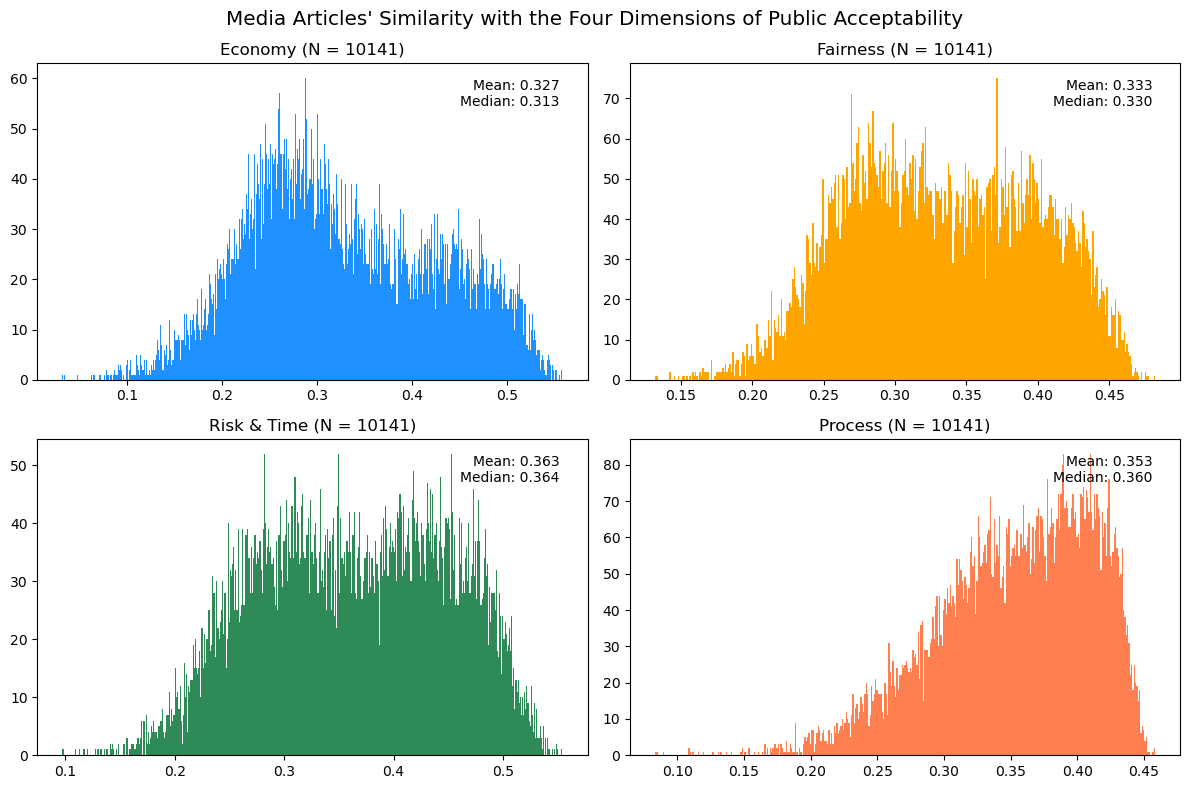

In [12]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df[sim_df['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df[sim_df['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df[sim_df['risktime_count'] >= filter_threshold]
sim_df_process = sim_df[sim_df['proc_count'] >= filter_threshold]
sim_df
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].hist(sim_df_economy['economy_sim_inin'], bins=np.arange(min(sim_df_economy['economy_sim_inin']), max(sim_df_economy['economy_sim_inin']) + 0.001, 0.001), color='dodgerblue')
axs[0,1].hist(sim_df_fairness['fairness_sim_inin'], bins=np.arange(min(sim_df_fairness['fairness_sim_inin']), max(sim_df_fairness['fairness_sim_inin']) + 0.001, 0.001), color='orange')  
axs[1,0].hist(sim_df_risktime['risktime_sim_inin'], bins=np.arange(min(sim_df_risktime['risktime_sim_inin']), max(sim_df_risktime['risktime_sim_inin']) + 0.001, 0.001), color='seagreen')
axs[1,1].hist(sim_df_process['process_sim_inin'], bins=np.arange(min(sim_df_process['process_sim_inin']), max(sim_df_process['process_sim_inin']) + 0.001, 0.001), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_inin'])
economy_median = np.median(sim_df_economy['economy_sim_inin'])
axs[0,0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_inin'])
fairness_median = np.median(sim_df_fairness['fairness_sim_inin'])
axs[0,1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_inin'])
risktime_median = np.median(sim_df_risktime['risktime_sim_inin'])
axs[1,0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_inin'])
process_median = np.median(sim_df_process['process_sim_inin'])
axs[1,1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Media Articles' Similarity with the Four Dimensions of Public Acceptability", size='x-large')

plt.tight_layout()
plt.show()

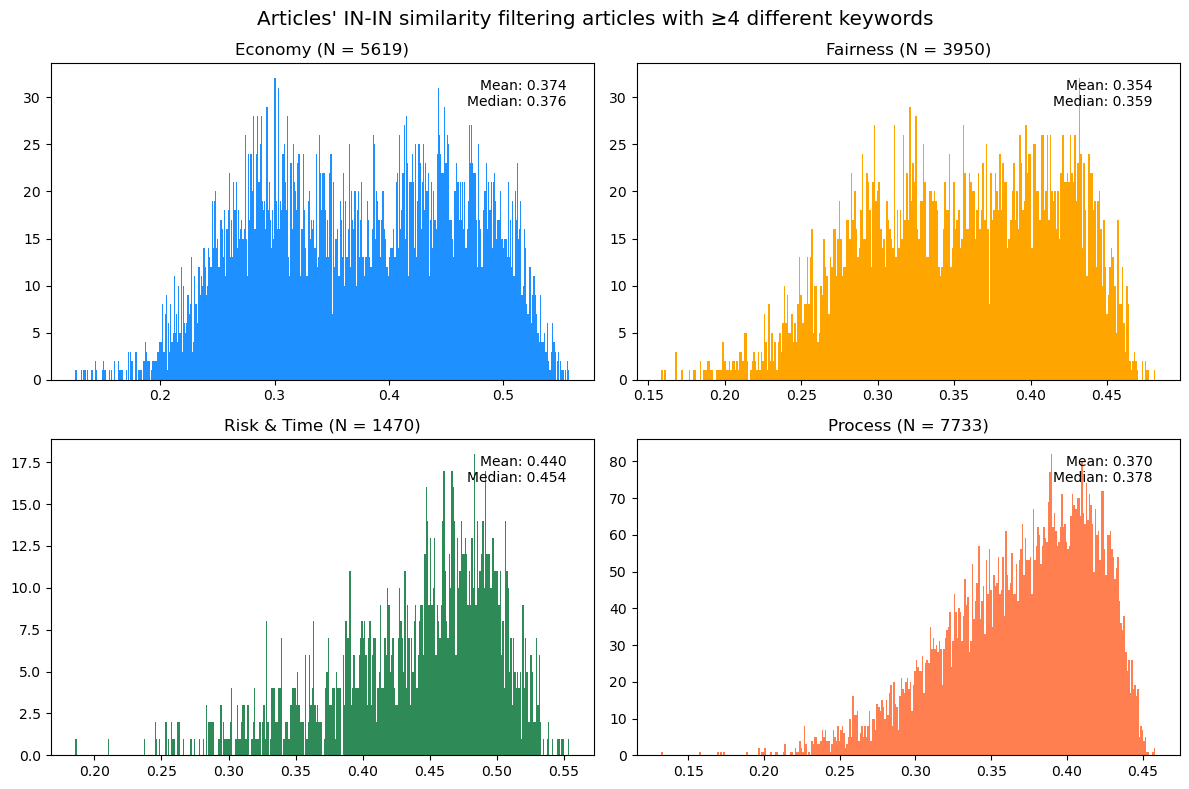

In [13]:
# Let's test what is the impact of keyword matches on the distribution of similarities.
# How many articles do we lose? Does the shape of the distribution change?

# Filtering on the number of keyword matches
filter_threshold = 4

# Sort for economy subplot
sim_df_economy = sim_df[sim_df['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df[sim_df['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df[sim_df['risktime_count'] >= filter_threshold]
sim_df_process = sim_df[sim_df['proc_count'] >= filter_threshold]
sim_df
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].hist(sim_df_economy['economy_sim_inin'], bins=np.arange(min(sim_df_economy['economy_sim_inin']), max(sim_df_economy['economy_sim_inin']) + 0.001, 0.001), color='dodgerblue')
axs[0,1].hist(sim_df_fairness['fairness_sim_inin'], bins=np.arange(min(sim_df_fairness['fairness_sim_inin']), max(sim_df_fairness['fairness_sim_inin']) + 0.001, 0.001), color='orange')  
axs[1,0].hist(sim_df_risktime['risktime_sim_inin'], bins=np.arange(min(sim_df_risktime['risktime_sim_inin']), max(sim_df_risktime['risktime_sim_inin']) + 0.001, 0.001), color='seagreen')
axs[1,1].hist(sim_df_process['process_sim_inin'], bins=np.arange(min(sim_df_process['process_sim_inin']), max(sim_df_process['process_sim_inin']) + 0.001, 0.001), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_inin'])
economy_median = np.median(sim_df_economy['economy_sim_inin'])
axs[0,0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_inin'])
fairness_median = np.median(sim_df_fairness['fairness_sim_inin'])
axs[0,1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_inin'])
risktime_median = np.median(sim_df_risktime['risktime_sim_inin'])
axs[1,0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_inin'])
process_median = np.median(sim_df_process['process_sim_inin'])
axs[1,1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Articles' IN-IN similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

## How to filter the corpus?

That's a key question. We tried different methods, including considering the shape of the distribution -- which unfortunately is not clearly bimodal -- and playing with knee/elbow of the similarities curve.

We found that the best method was to combine keyword matches and percentile cuts. Hence, we impose a low keyword matches filter, selecting only documents with 2 different keywords. Then, we select only articles from the first quartile of the distribution of similarities.

In [14]:
# Filtering on the number of keyword matches
filter_threshold = 2

# Filter out articles with less than 2 keyword matches and select those ≥50th percentile
top_economy = sim_df[sim_df['econ_count'] >= filter_threshold].nlargest(int(len(sim_df_economy) * 0.25), 'economy_sim_inin')
top_fairness = sim_df[sim_df['fair_count'] >= filter_threshold].nlargest(int(len(sim_df_fairness) * 0.25), 'fairness_sim_inin')
top_risktime = sim_df[sim_df['risktime_count'] >= filter_threshold].nlargest(int(len(sim_df_risktime) * 0.25), 'risktime_sim_inin')
top_process = sim_df[sim_df['proc_count'] >= filter_threshold].nlargest(int(len(sim_df_process) * 0.25), 'process_sim_inin')

# Prepare the four corpa
corpus_economy = top_economy['article_processed']
corpus_fairness = top_fairness['article_processed']
corpus_risktime = top_risktime['article_processed']
corpus_process = top_process['article_processed']

print('The number of relevant articles for each corpus is:' +
      '\n  -  Economic dimension: ' + str(len(corpus_economy)) +
      '\n  -  Fairness dimension: ' + str(len(corpus_fairness)) +
      '\n  -  Risk & Time dimension: ' + str(len(corpus_risktime)) +
      '\n  -  Process dimension: ' + str(len(corpus_process)))

The number of relevant articles for each corpus is:
  -  Economic dimension: 1404
  -  Fairness dimension: 987
  -  Risk & Time dimension: 367
  -  Process dimension: 1933


## Topic modeling: Economic dimension

In [15]:
# Initialize variables which will be used later
n_features = 5000
n_components = 20 
n_top_words = 15 

In [16]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_economy = tfidf_vectorizer.fit_transform(corpus_economy)

In [17]:
# Perform NMF
seed = 42
nmf_economy = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_economy)

In [18]:
def plot_top_words(model, feature_names, n_top_words, title, name, n_topics, n_seed):
    fig, axes = plt.subplots(4, 5, figsize=(40, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=50)

    plt.subplots_adjust(top=0.93, bottom=0.05, wspace=0.7, hspace=0.2)
    #plt.savefig('./figures/'+str(name)+'_topics'+str(n_topics)+'_seed'+str(n_seed)+'.png')
    plt.show()

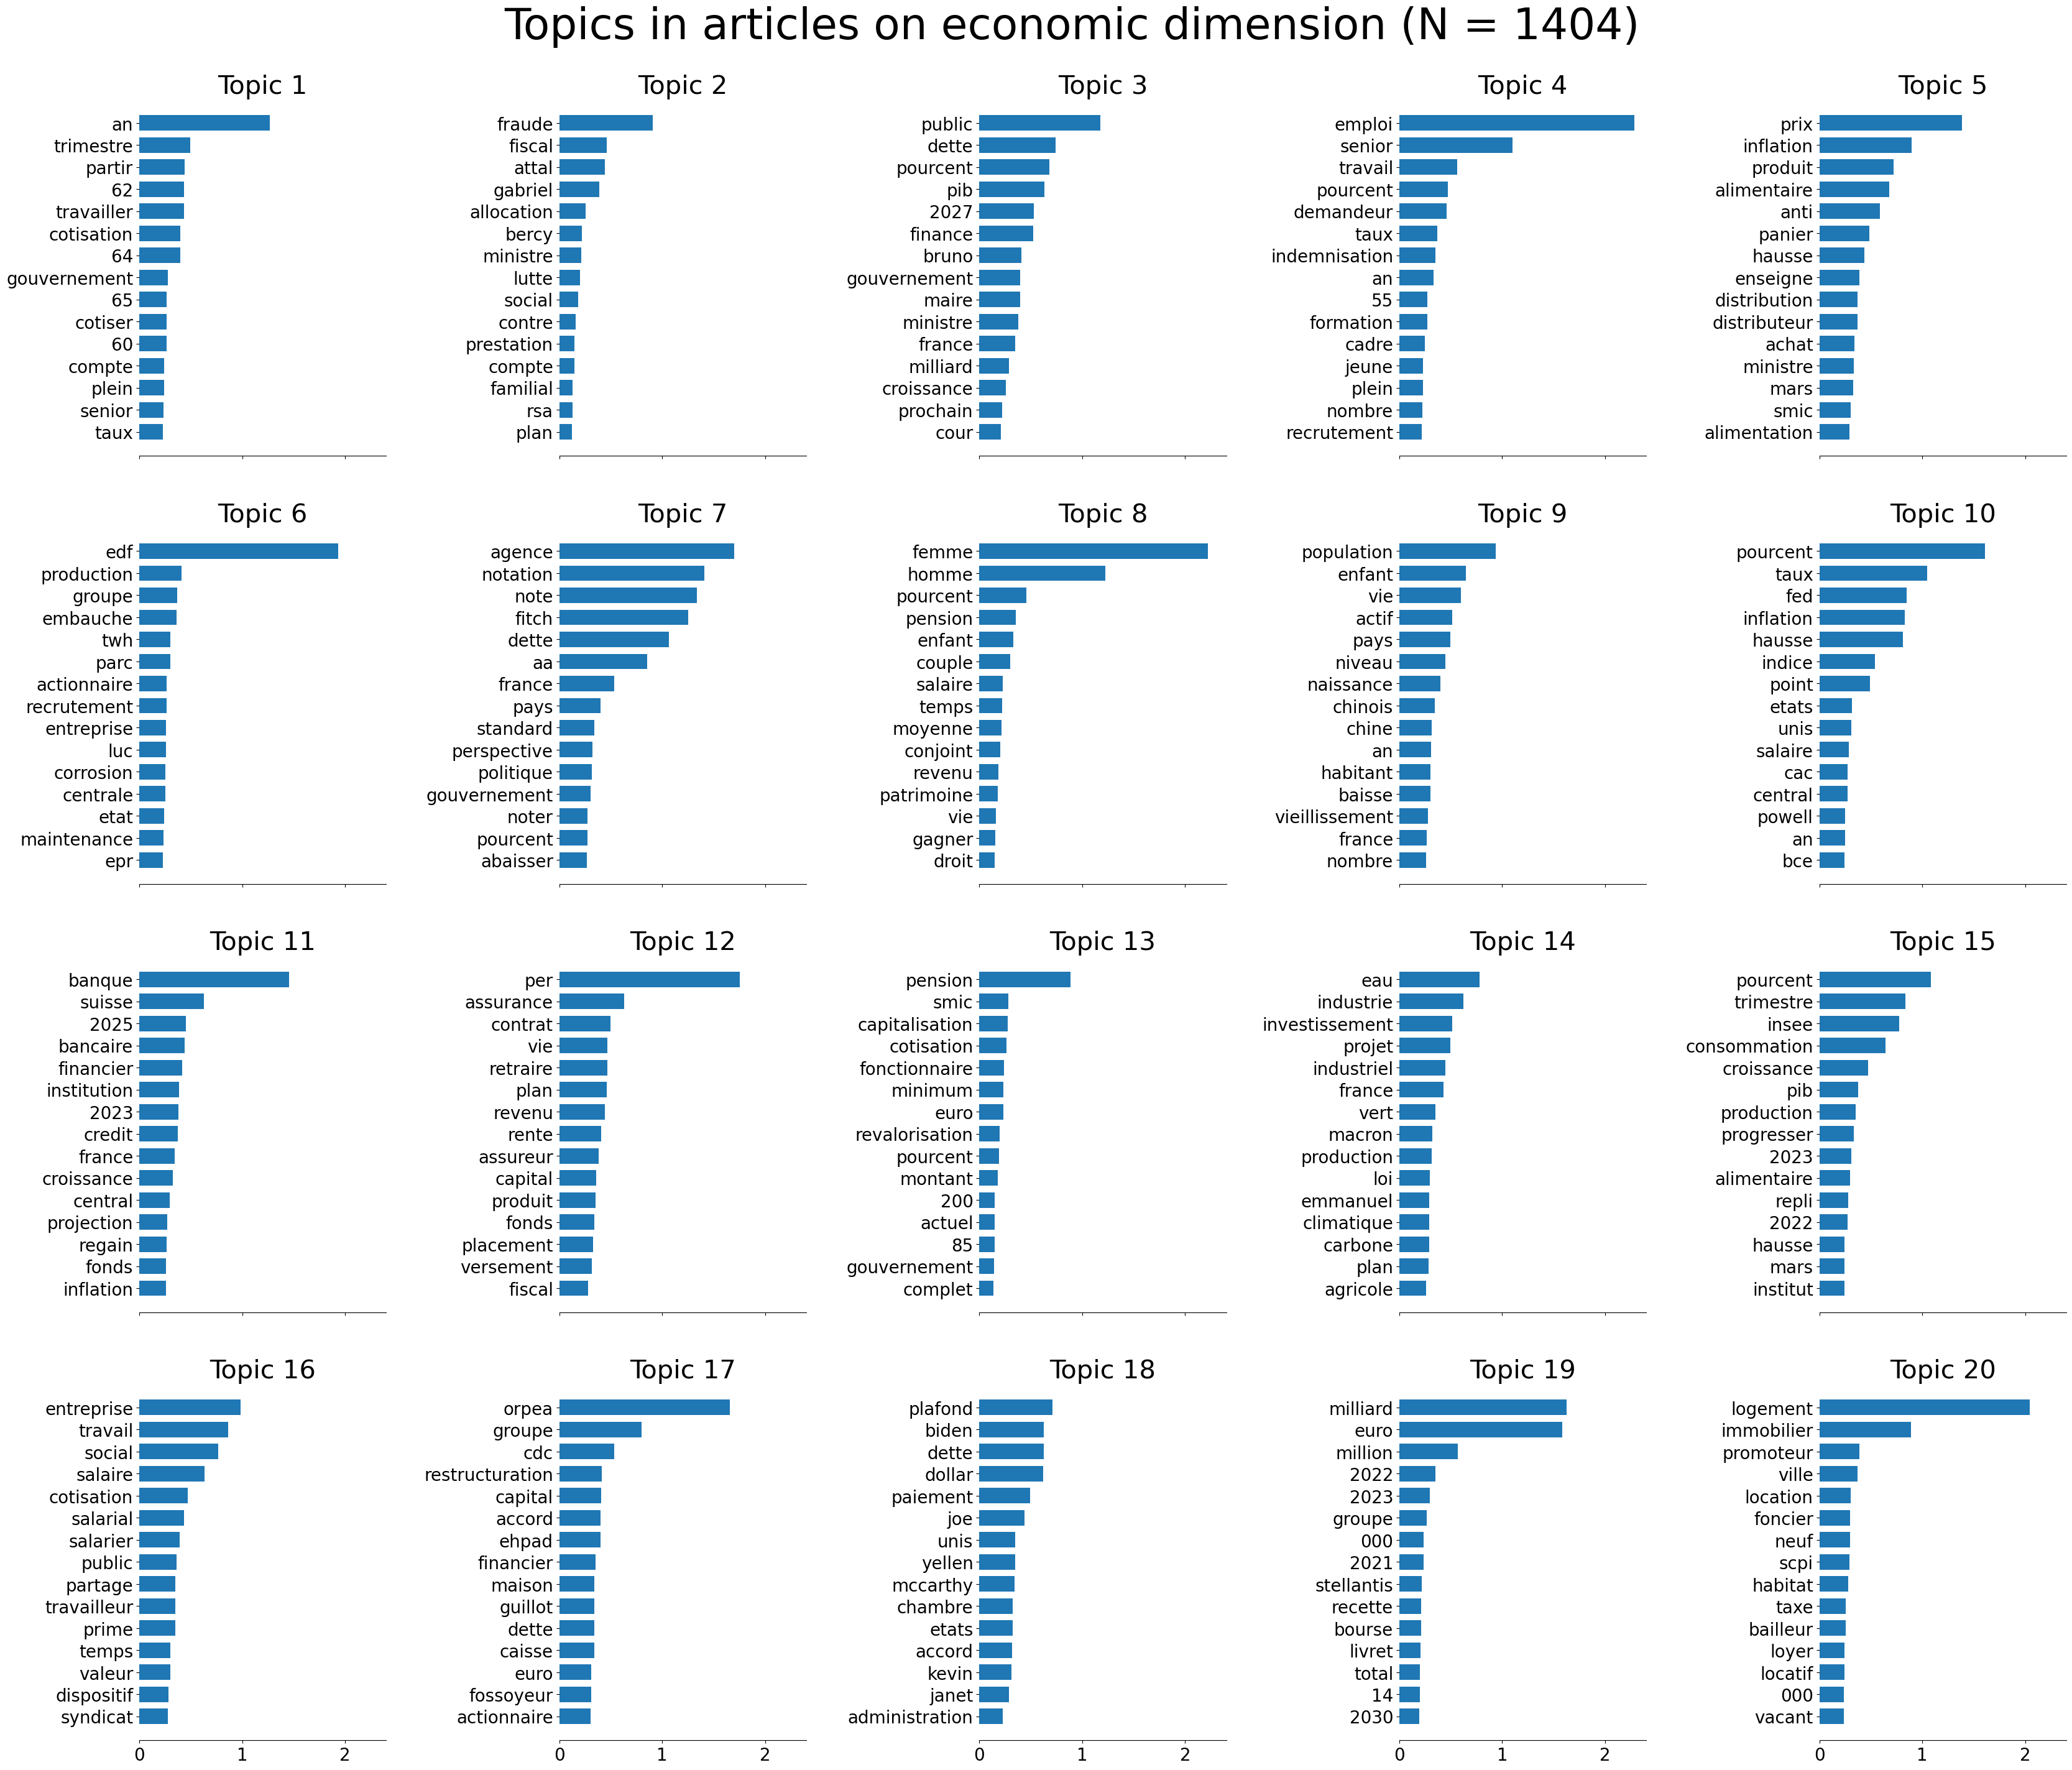

In [19]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_economy, tfidf_feature_names, n_top_words, f"Topics in articles on economic dimension (N = {len(corpus_economy)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [20]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_economy.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_economy = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_economy.extend(top_3)

In [21]:
# Get the document-topic matrix
doc_topic_matrix = nmf_economy.transform(tfidf_economy)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_economy.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

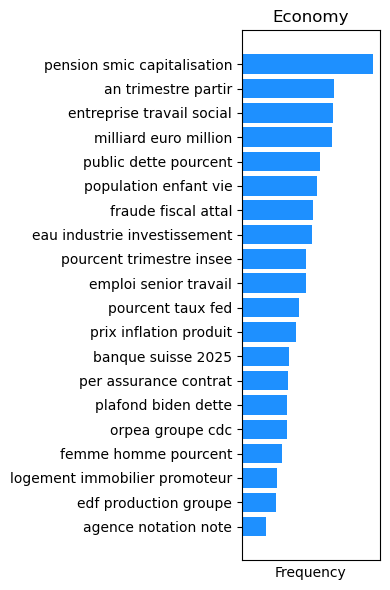

In [22]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 6)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='dodgerblue')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title("Economy")
plt.tight_layout()
plt.show()

## Fairness

In [23]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_fairness = tfidf_vectorizer.fit_transform(corpus_fairness)

In [24]:
# Perform NMF
seed = 42
nmf_fairness = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_fairness)

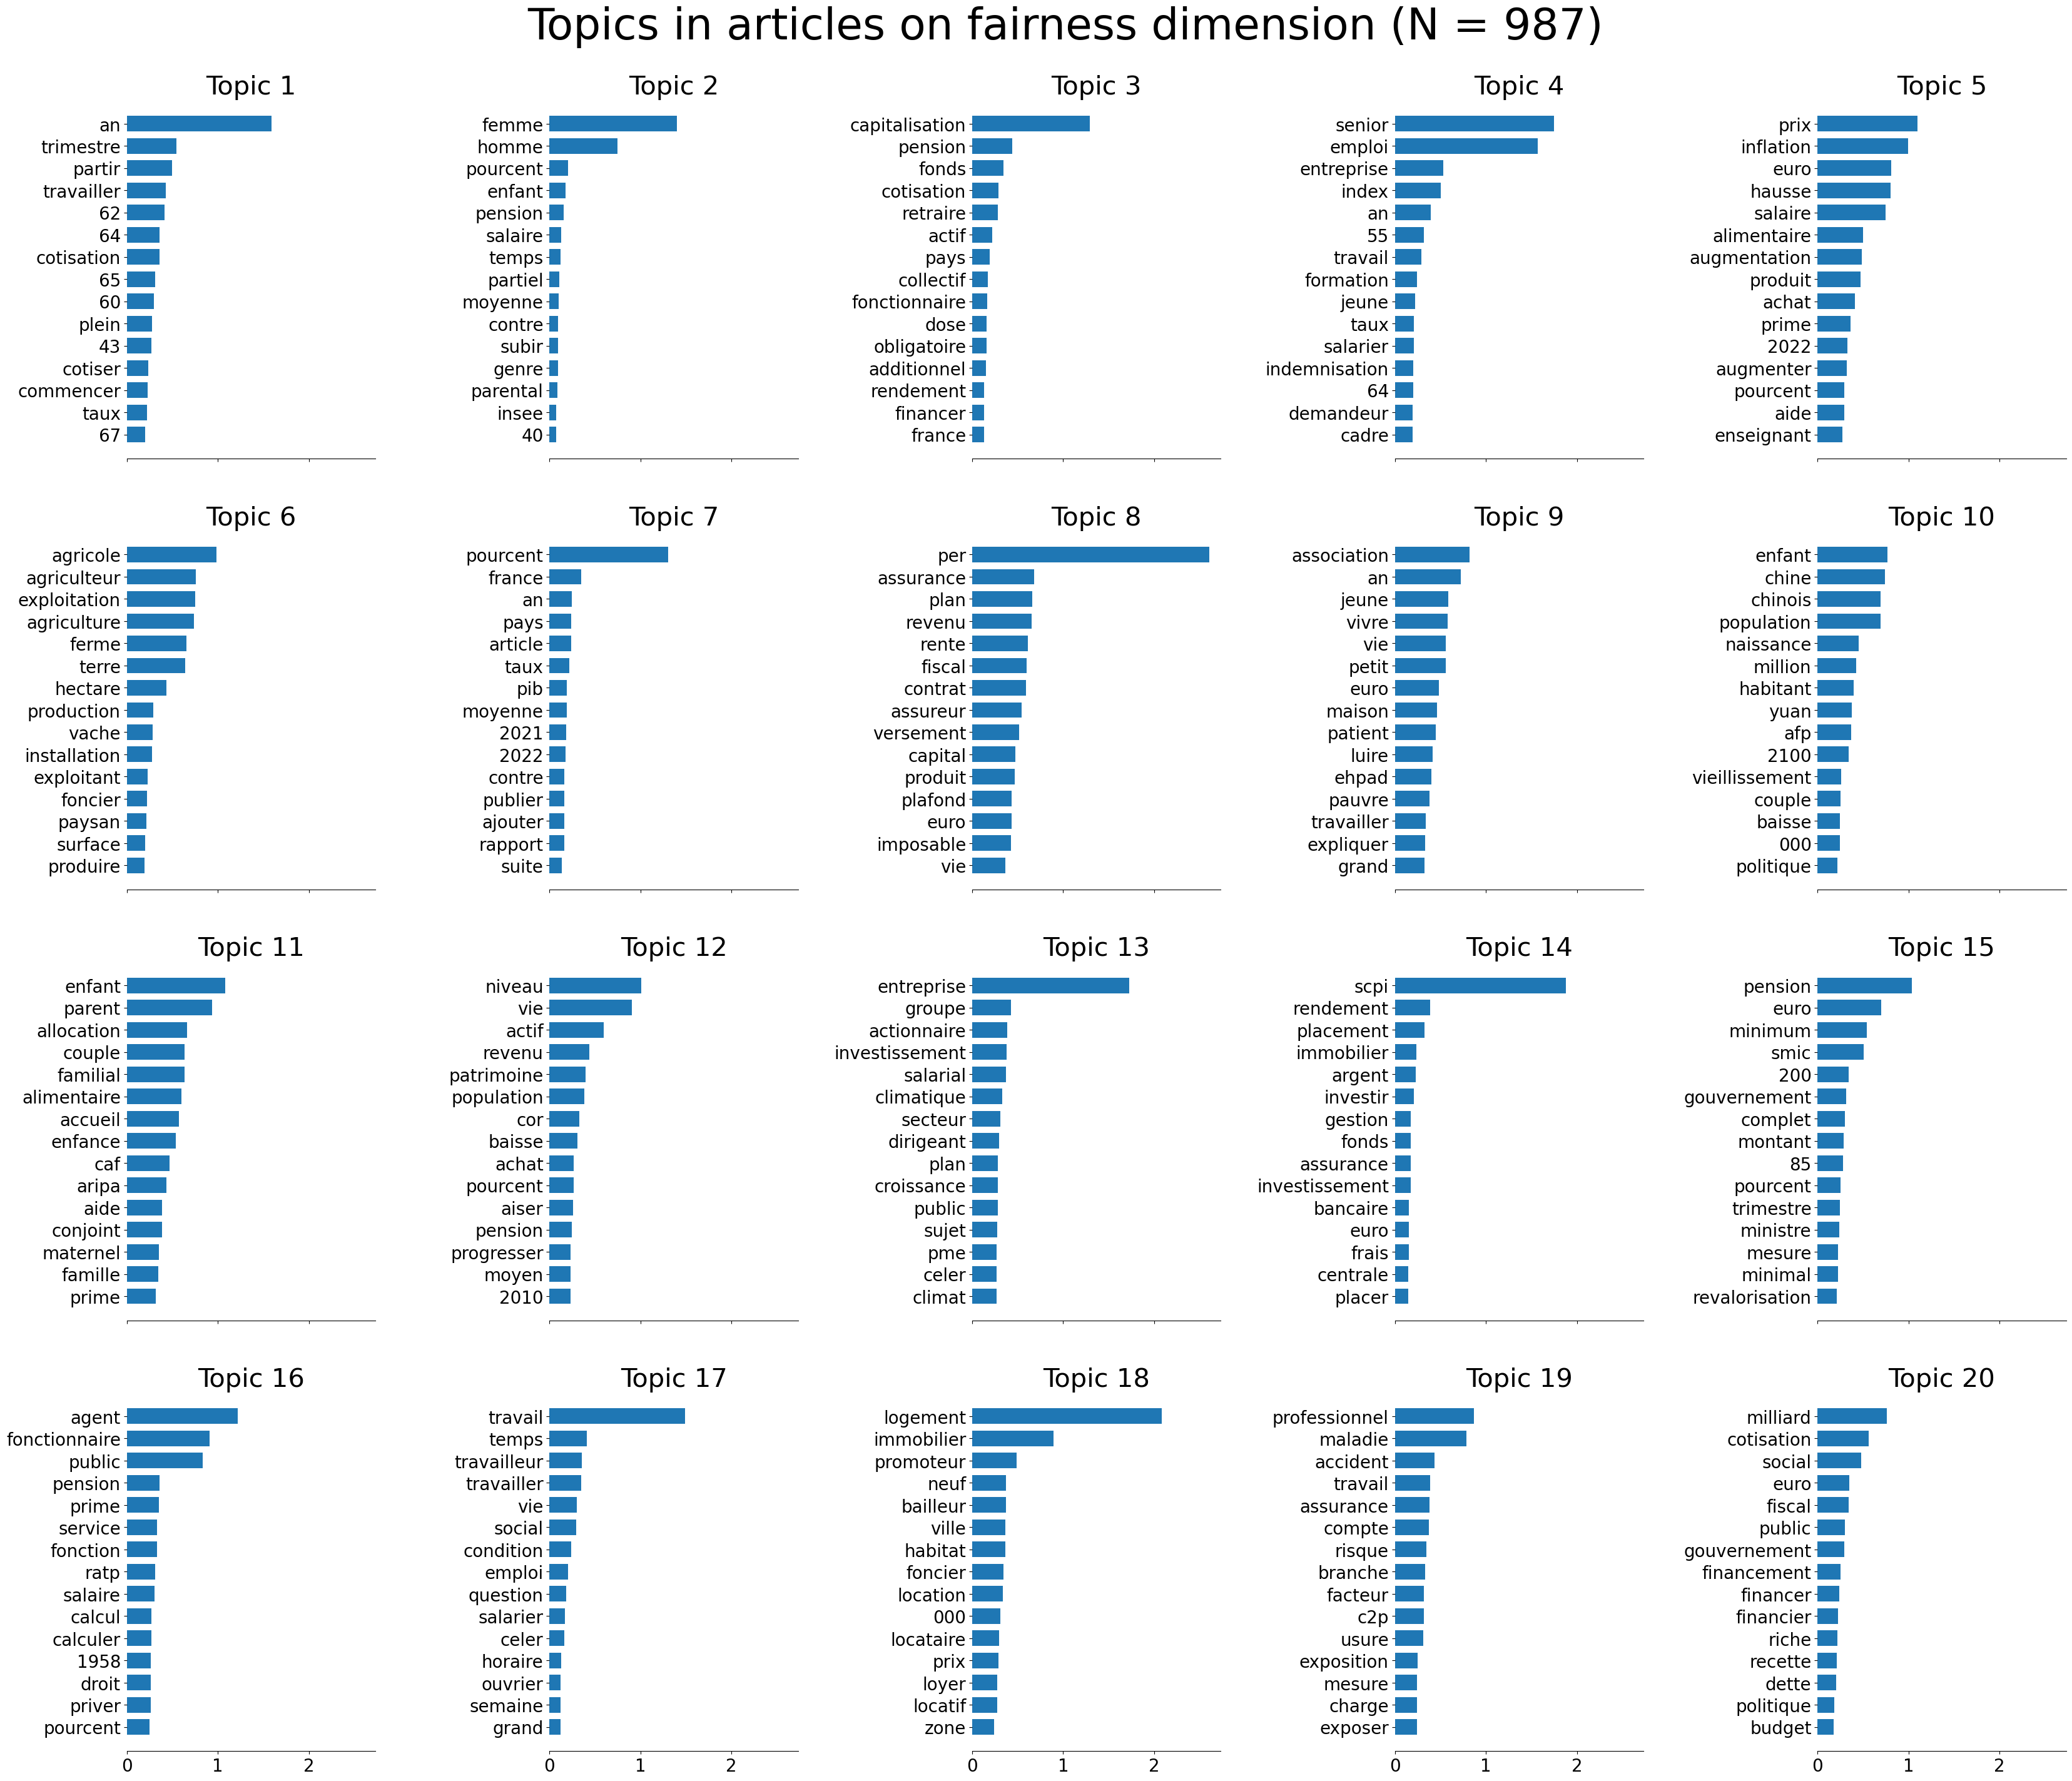

In [25]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_fairness, tfidf_feature_names, n_top_words, f"Topics in articles on fairness dimension (N = {len(corpus_fairness)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [26]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_fairness.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_fairness = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_fairness.extend(top_3)

In [27]:
# Get the document-topic matrix
doc_topic_matrix = nmf_fairness.transform(tfidf_fairness)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_fairness.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

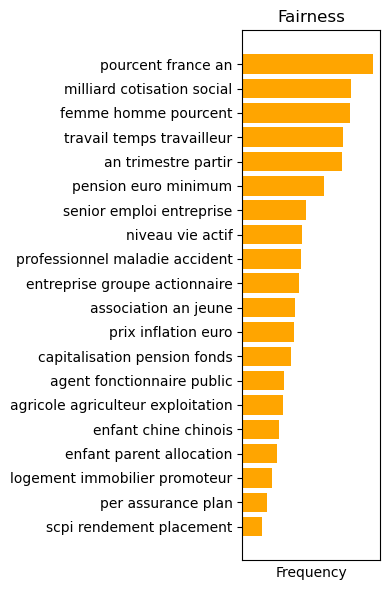

In [28]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 6)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='orange')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title("Fairness")
plt.tight_layout()
plt.show()

## Risk & Time

In [29]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_risktime = tfidf_vectorizer.fit_transform(corpus_risktime)

In [30]:
# Perform NMF
seed = 42
nmf_risktime = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_risktime)

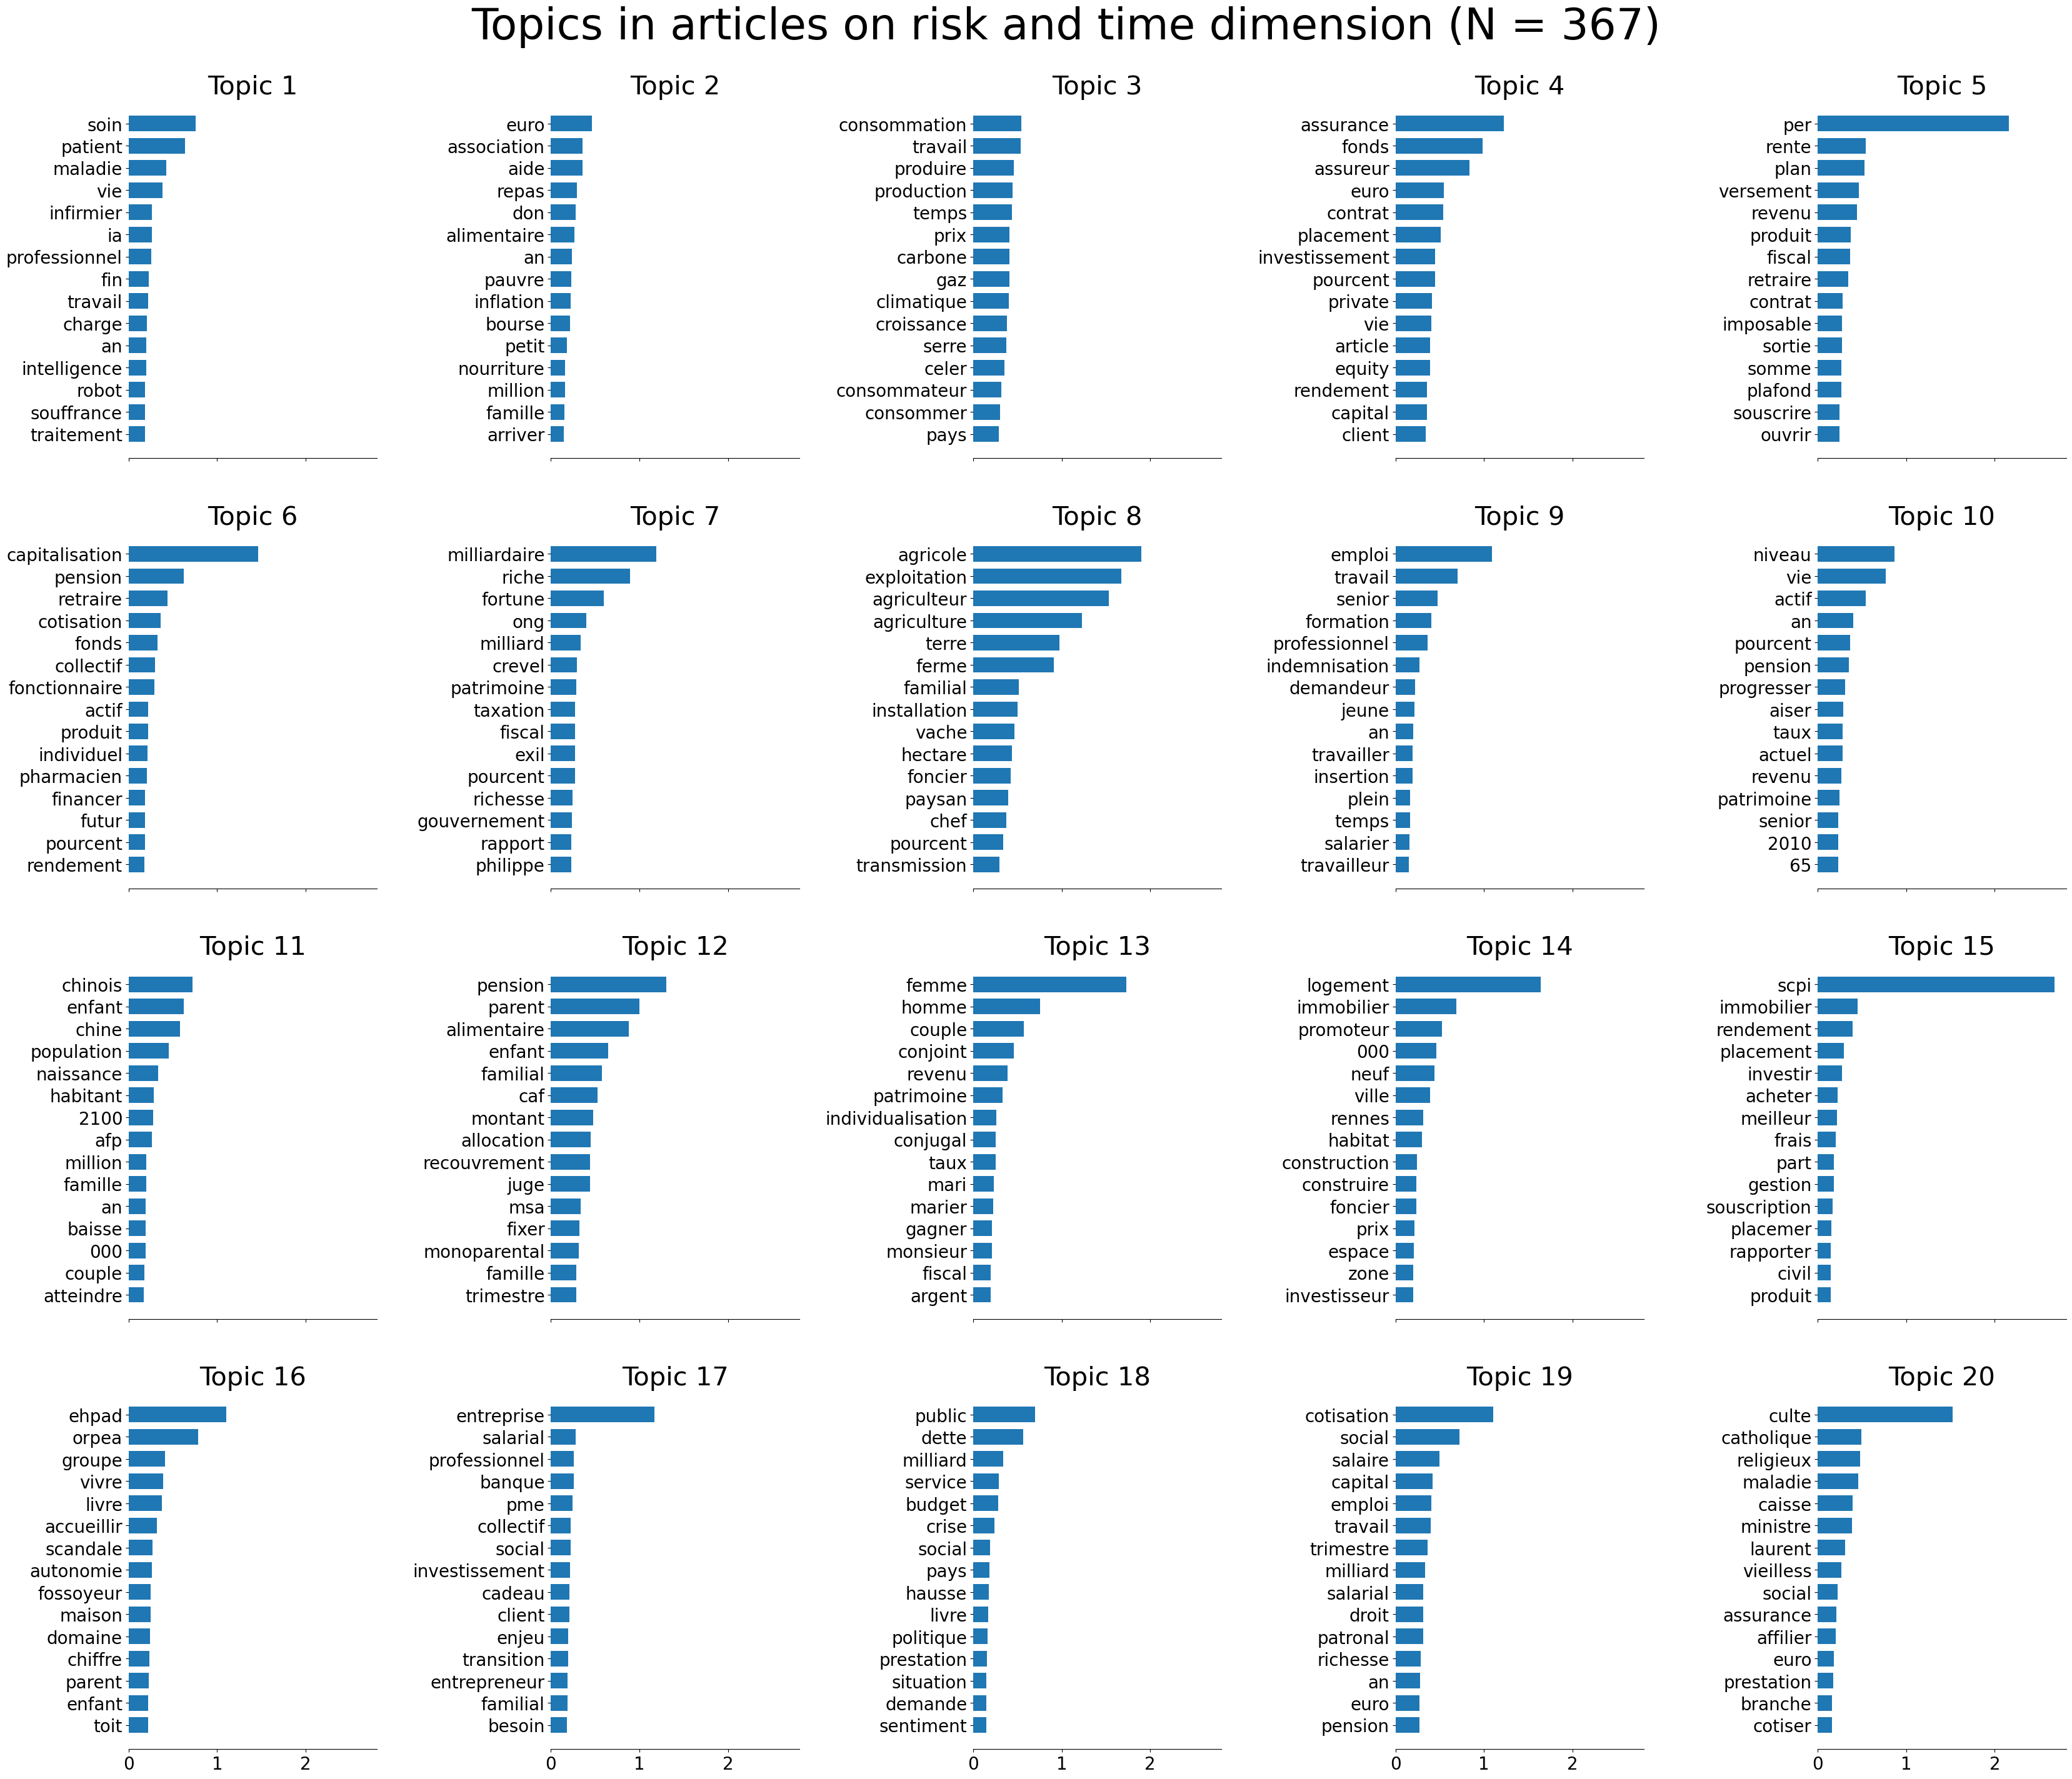

In [31]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_risktime, tfidf_feature_names, n_top_words, f"Topics in articles on risk and time dimension (N = {len(corpus_risktime)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [32]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_risktime.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_risktime = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_risktime.extend(top_3)

In [33]:
# Get the document-topic matrix
doc_topic_matrix = nmf_risktime.transform(tfidf_risktime)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_risktime.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

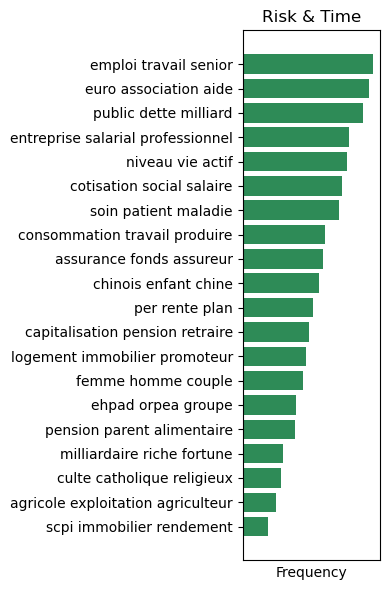

In [34]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 6)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='seagreen')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title("Risk & Time")
plt.tight_layout()
plt.show()

## Process

In [35]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_process = tfidf_vectorizer.fit_transform(corpus_process)

In [36]:
# Perform NMF
seed = 42
nmf_process = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_process)

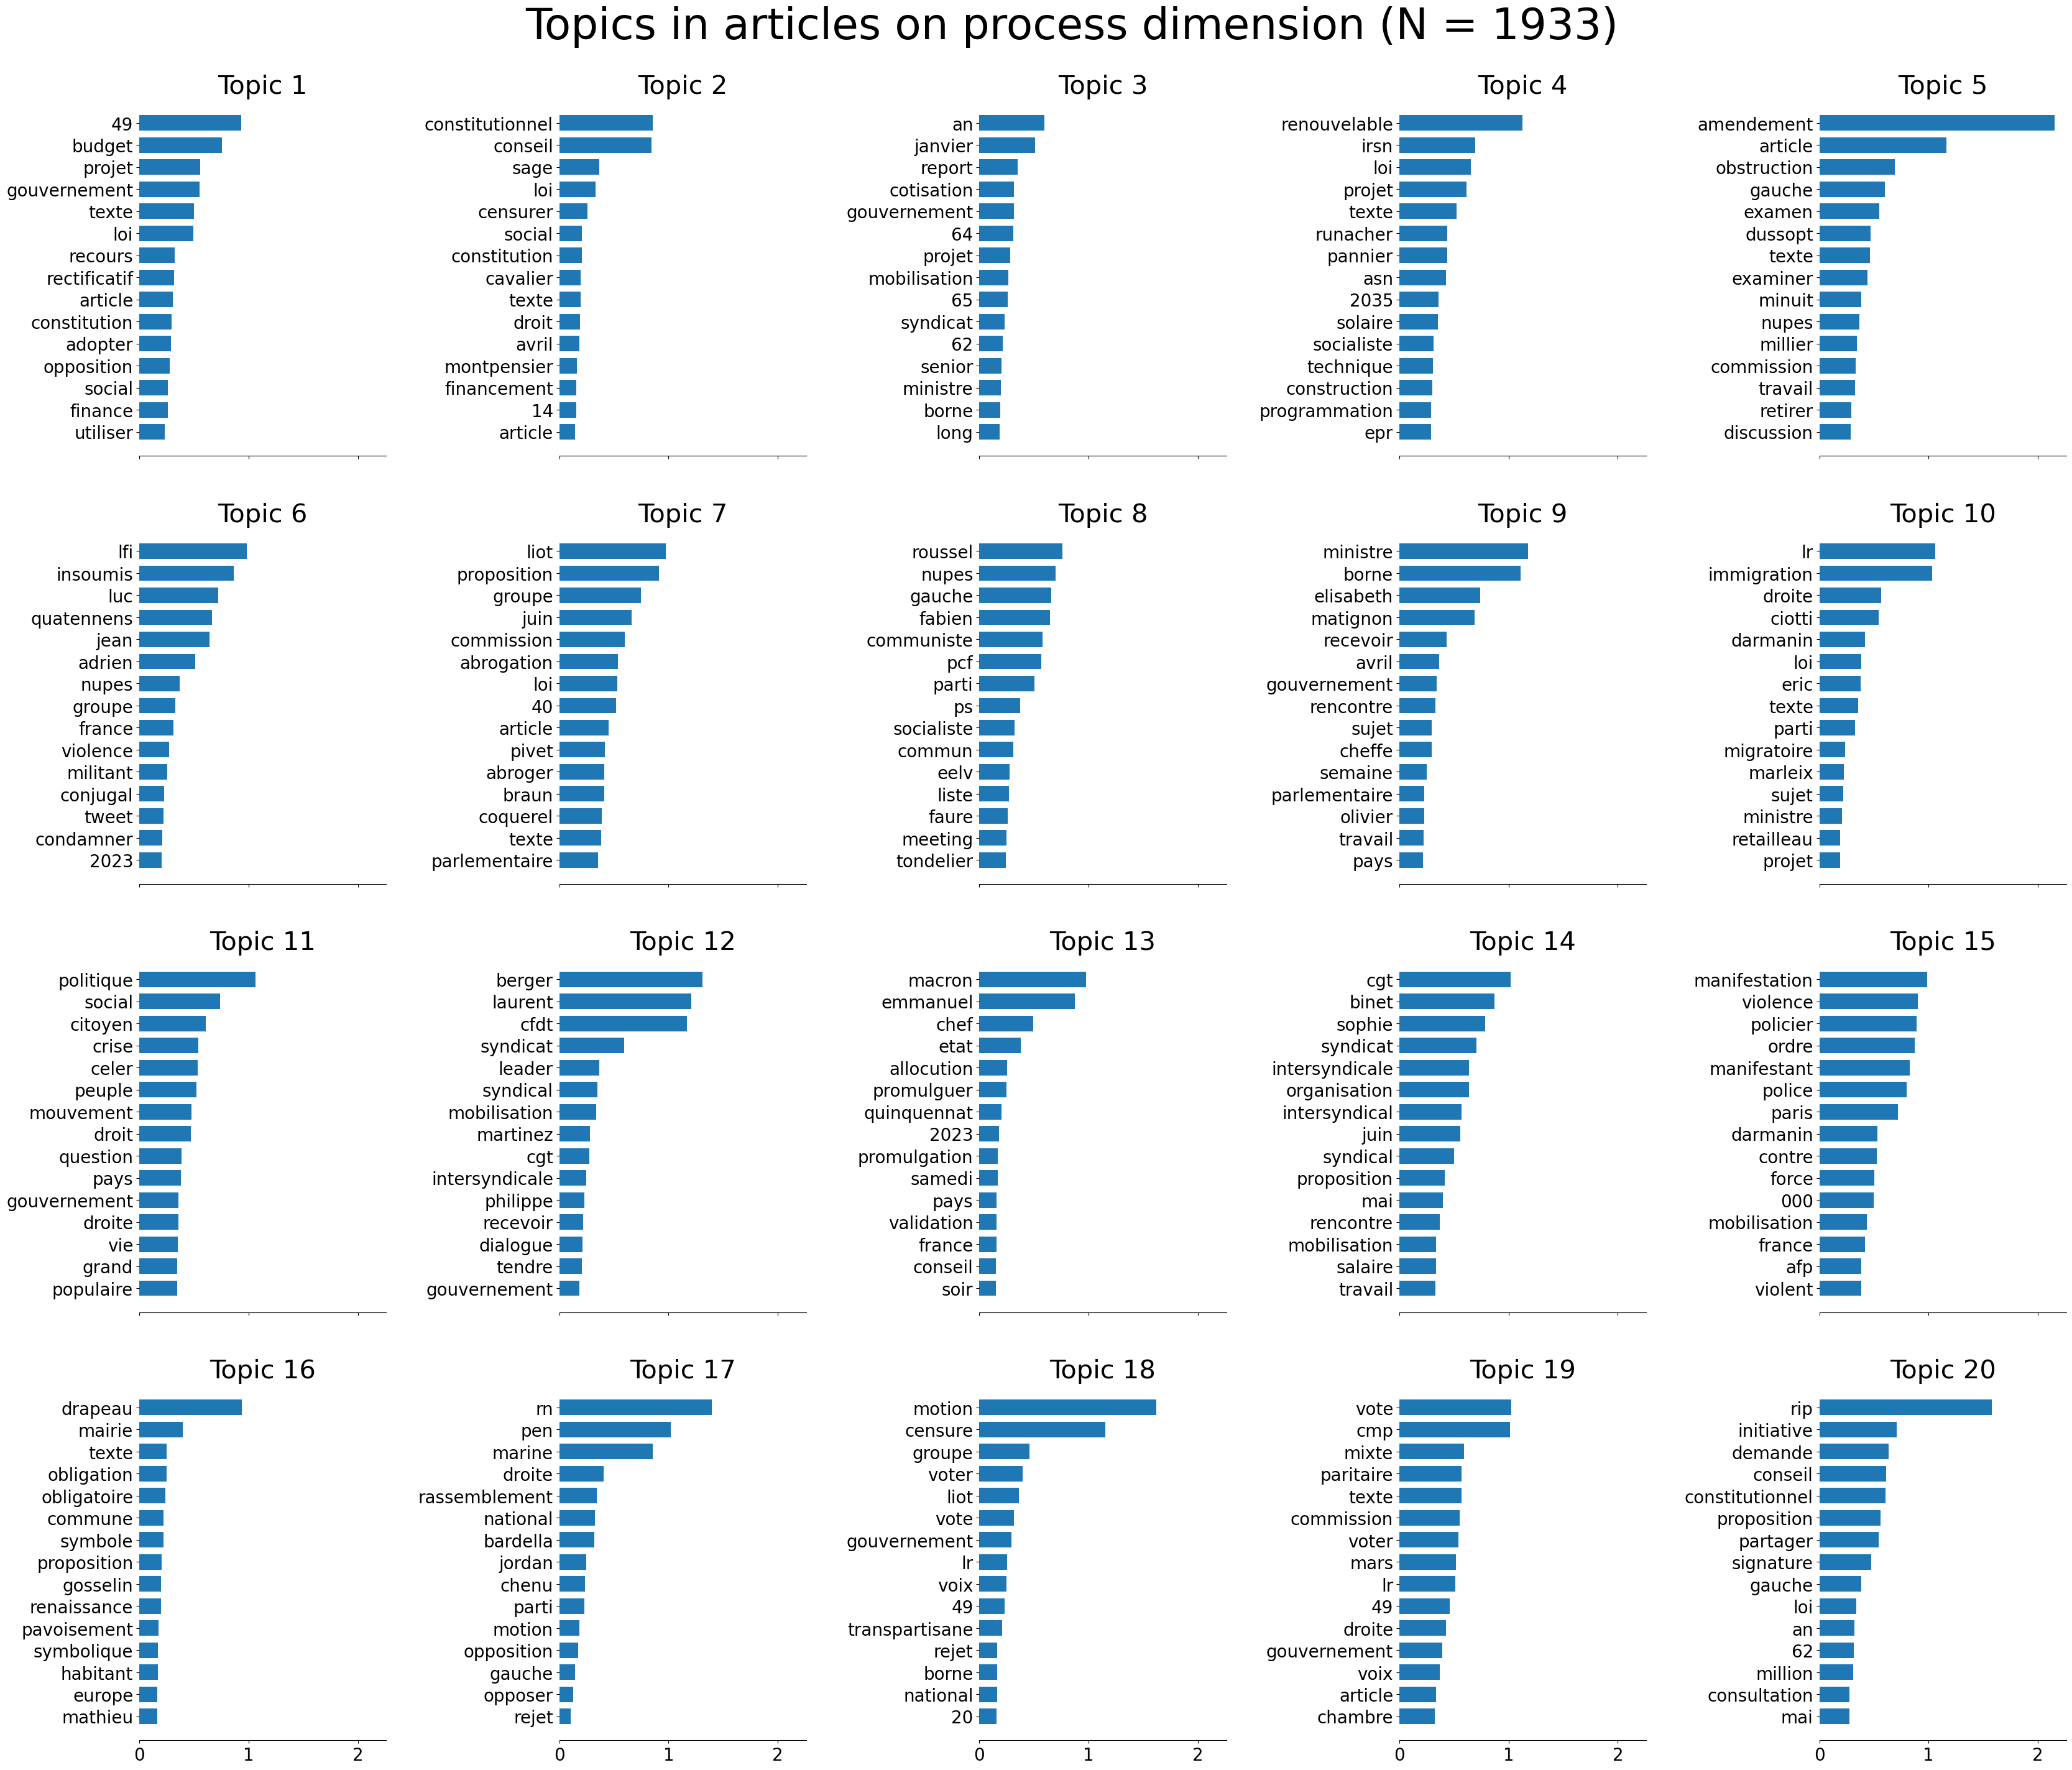

In [37]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_process, tfidf_feature_names, n_top_words, f"Topics in articles on process dimension (N = {len(corpus_process)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [38]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_process.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_process = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_process.extend(top_3)

In [39]:
# Get the document-topic matrix
doc_topic_matrix = nmf_process.transform(tfidf_process)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_process.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

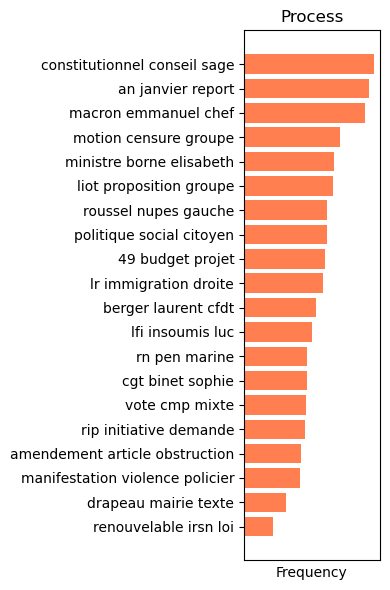

In [40]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 6)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='coral')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title("Process")
plt.tight_layout()
plt.show()